In [1]:
#Import libraries necessary to do the analysis
import km3io as kio
import km3db
import km3pipe as kp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import figure
from progressbar import ProgressBar
import pickle
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
from numpy import ones,vstack
from numpy.linalg import lstsq

import warnings
warnings.filterwarnings("ignore")

/home/stefanescu/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
2021-12-14 09:23:30 caeubuntu3 matplotlib.font_manager[50256] WARNING Matplotlib is building the font cache; this may take a moment.


In [ ]:
##Functions Definition!!!

In [2]:
def DOM():
    """Reads DOM file and store list of positions, ids and dictionary"""


    #Read DOMS information on positions and id
    det = kp.hardware.Detector('/home/stefanescu/internship/muonstopwork/KM3NeT_00000049_20200625.detx')
    
    #Store position of DOMS in a np.array ([xxx][yyyy][zzzz])
    dom_x = []
    dom_y = []
    dom_z = []
    dom_id = []

    for dom,pos in det.dom_positions.items():
        dom_x.append(pos[0])
        dom_y.append(pos[1])
        dom_z.append(pos[2])
        dom_id.append(dom)
    
    dom_positions = np.array((dom_x,dom_y,dom_z))

    #Transpose the arrays to make a for loop for each distance
    dom_positions_bis = dom_positions.T
    

    #create dictionary of id vs index
    dict_id = {}
    for i in range(len(dom_positions_bis)):
        dict_id[i] = dom_id[i]

        
    return dom_positions_bis, dict_id
    

In [3]:
dom_positions, dict_id = DOM()

++ Detector: Parsing the DETX header
++ Detector: Reading PMT information...
++ Detector: Done.


In [4]:
def plotdom():
    """Plot a 3D plot of DOM"""
    
    #3D plot stop positions cuts_bis

    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')

    ax.scatter3D(dom_positions.T[0],dom_positions.T[1],dom_positions.T[2], s=50, c="red",depthshade=False, marker="o",label="second")
    
    ax.set_title("DOM Positions")
    ax.set_xlim([430,490])
    ax.set_ylim([550,600])
    ax.set_zlim([0,250])
    
    return plt.show()

In [5]:
def linear(xmin1,ymin1,xmax1,ymax1):
    """Returns m and n for 2 points"""
    points = [(xmin1,ymin1),(xmax1,ymax1)]
    x_coords, y_coords = zip(*points)
    A = vstack([x_coords,ones(len(x_coords))]).T
    m, n = lstsq(A, y_coords)[0]
    #print("Line Solution is y = {m}x + {n}".format(m=m,n=n))
    return m, n

In [6]:
def VolumeCut(pos_stop_bis,zsup,zinf,yred,xred):
    """Returns boolean list for cut based on stop positions inside a given volume, plus cuts in each direction
    Returns also the stop positions as a list of coordinates"""

    #Compute cuts_volume
    cuts_volume = []    
    
    #Define limits of our volume, taking into account the cut in each direction
    y_lim = [564.9+yred,584.1-yred] #y limits
    z_lim = [30+zinf,192-zsup] #z limits
    
    print("Ylim is:", y_lim)
    print("Zlim is:", z_lim)

    #two vertices of x in the x-y plane
    xmin1 = 431+xred
    xmax1 = 441+xred
    ymin1 = y_lim[1]
    ymax1 = y_lim[0]
    
    xmin2 = 474-xred
    xmax2 = 484-xred
    ymin2 = y_lim[1]
    ymax2 = y_lim[0]
    
    #linear regressions for the two extremes of paralelepipoid
    m1, n1 = linear(xmin1,ymin1,xmax1,ymax1)
    m2, n2 = linear(xmin2,ymin2,xmax2,ymax2)
    
    #Loop over all events
    coordinates = []
    
    for i in range(len(pos_stop_bis)):   
        
        x,y,z = pos_stop_bis[i,0],pos_stop_bis[i,1],pos_stop_bis[i,2] #coordinates of points of the events
        
            
        if (z >= z_lim[0]) & (z <= z_lim[1]): #check if in z range
            
            if (y >= y_lim[0]) & (y <= y_lim[1]):  #check if in y range
                
                if (x >= xmax1) & (x <= xmin2): #check if x in the middle of the paralelepipoid, if so, point fall inside volume
                    cuts_volume.append(True)
                    coordinates.append([x,y,z])
                    
                elif (x >= xmin1) & (x <= xmax1): #check if for first extreme, point falls inside the volume
                    y1 = m1*x+n1
                    if y > y1:
                        cuts_volume.append(True)
                        coordinates.append([x,y,z])
                    else:
                        cuts_volume.append(False)
                        
                elif (x >= xmin2) & (x <= xmax2): #check if for second extreme, point falls inside the volume
                    y2 = m2*x+n2
                    if y < y2:
                        cuts_volume.append(True)
                        coordinates.append([x,y,z])
                    else:
                        cuts_volume.append(False)
                    

                else:
                    cuts_volume.append(False)
            else:
                cuts_volume.append(False)
        else:
            cuts_volume.append(False)


    return cuts_volume, coordinates


In [7]:
def Stops(file,cuts):
    """Calculate stop postions of file, based on boolean list of cuts"""

    #Read file using kio
    f = kio.OfflineReader(file)
    
    #Array of initial position x, y and z coordinates for each event considering the cuts_2
    pos_start = [f.events.tracks.pos_x[cuts][:,0].__array__(),f.events.tracks.pos_y[cuts][:,0].__array__(),f.events.tracks.pos_z[cuts][:,0].__array__()] 

    #Add all positions together, array of arrays
    pos_start = np.stack(pos_start)
    
    #Fitinf for each track of each event. Get all fitinf of 0th and 10th element of fitinf object (Trak lenght)
    trackLength = f.events.tracks.fitinf[cuts][:,0,10].__array__()
    
    #stop postion, as pos start + track
    pos_stop_x  = pos_start[0,:] + f.events.tracks.dir_x[cuts][:,0].__array__()*trackLength # for x
    pos_stop_y  = pos_start[1,:] + f.events.tracks.dir_y[cuts][:,0].__array__()*trackLength # for y
    pos_stop_z  = pos_start[2,:] + f.events.tracks.dir_z[cuts][:,0].__array__()*trackLength # for z

    #Add all positions together, array of arrays
    pos_stop = np.stack((pos_stop_x, pos_stop_y, pos_stop_z))

    #Transpose the array to make a for loop for each distance
    pos_stop_bis = pos_stop.T
    
    return pos_stop, pos_stop_bis, pos_start, trackLength
    

In [8]:
def GUILLON_Cuts(file,E=2,lik=200,dir_z=None,zsup=0,zinf=0,yred=0,xred=0):
    """Returns dataframe for a km3net root file, cutting events based on E, lik, dir_z, Volume.
    Default values: E=2.GeV, lik=200, dir_z=All,Volume=All initial volume, """
    
    
    #Read file using kio
    f = kio.OfflineReader(file)
    print("File readed...")
    
    #total number of events
    total_events = len(f.events)
    
    print("Filtering based on E and lik...")
    #array of booleans, true if n_tracks >= 1
    haveTrk = np.array(f.events.n_tracks, dtype=bool)
    
    #array of booleans for E and lik filters + haveTrk
    cuts_1 = np.array((f.events.tracks.E[haveTrk][:,0] >= E) & (f.events.tracks.lik[haveTrk][:,0] >= lik))
    print("Filtration completed, filtering in dir_z...")
    
    #filter for z_direction, if not specified, just an array of True values
    if dir_z:
        cuts_z = np.array(f.events.tracks.dir_z[haveTrk][:,0] <= dir_z)
    else:
        cuts_z = np.broadcast_to(True,(1,total_events))
        
        
    #cuts of E, lik, z boolean array
    cuts_2 = cuts_1 & cuts_z
    
    print("Filtration complted, calculating stop positions...")
    
    
    #Call Stops function to compute stop postions based on cuts_2, as well as start positions and tracklenght
    pos_stop, pos_stop_bis, pos_start, trackLength = Stops(file,cuts_2)
    
    print("Stop postions calculated")
    print("Computing Volume information...")
    
    #Call VolumeCut function to compute cuts_volume 
    cuts_volume, coordinates = VolumeCut(pos_stop_bis,zsup,zinf,yred,xred)
    
    
    #Perform final cut, using cuts_2 and cuts_R_dom
    filtered_events = f.events[cuts_2][cuts_volume]
    
    print("Filtration finished")
    
    #Calculate again final postions for the data, based on the two cuts, in order to have a proper dataframe, and don't loose
    #track of events id... (Due to the fact of the double filtration, step needed for solving computing problems)
    print("Recalculating stop postions")
        
    #Array of initial position x, y and z coordinates for each event considering the cuts_2 and cuts_R_dom
    pos_start_f = [f.events.tracks.pos_x[cuts_2][cuts_volume][:,0].__array__(),f.events.tracks.pos_y[cuts_2][cuts_volume][:,0].__array__(),f.events.tracks.pos_z[cuts_2][cuts_volume][:,0].__array__()] 

    #Add all positions together, array of arrays
    pos_start_f = np.stack(pos_start_f)
    
    #Fitinf for each track of each event. Get all fitinf of 0th and 10th element of fitinf object (Trak lenght)
    trackLength_f = f.events.tracks.fitinf[cuts_2][cuts_volume][:,0,10].__array__()
    
    #stop postion, as pos start + track
    pos_stop_x_f  = pos_start_f[0,:] + f.events.tracks.dir_x[cuts_2][cuts_volume][:,0].__array__()*trackLength_f # for x
    pos_stop_y_f  = pos_start_f[1,:] + f.events.tracks.dir_y[cuts_2][cuts_volume][:,0].__array__()*trackLength_f # for y
    pos_stop_z_f  = pos_start_f[2,:] + f.events.tracks.dir_z[cuts_2][cuts_volume][:,0].__array__()*trackLength_f # for z

    #Add all positions together, array of arrays
    pos_stop_f = np.stack((pos_stop_x_f, pos_stop_y_f, pos_stop_z_f))

        
    #Calculate % of filtered events
    filtered_events_n = len(filtered_events)
    print(str("{:.2f}".format((total_events-filtered_events_n)*100/total_events))+"% of events filtered")
    
    #Create the dataframe, including also id!!!
    print("Creating dataframe with all desired variables for the filtered events")
    
    #DataFrame all list
    data_tuples = list(zip(filtered_events.id,filtered_events.run_id,filtered_events.t_sec,filtered_events.t_ns,filtered_events.events.tracks.E[:,0].__array__(),filtered_events.events.tracks.lik[:,0].__array__(),filtered_events.events.tracks.dir_x[:,0].__array__(),filtered_events.events.tracks.dir_y[:,0].__array__(),filtered_events.events.tracks.dir_z[:,0].__array__(),pos_start_f[0],pos_start_f[1],pos_start_f[2],trackLength_f,pos_stop_f[0],pos_stop_f[1],pos_stop_f[2]))
    df_cuts = pd.DataFrame(data_tuples, columns=['id','run_id','t_sec','t_ns','E_Gev',"lik","dir_x","dir_y","dir_z","start_x","start_y","start_z","trackLength","stop_x","stop_y","stop_z"])
    
    
    return df_cuts

In [9]:
def plot3D(df,dom_positions):
    """Plots the stop positions in a 3D plot"""
    
    #3D plot stop positions cuts_bis

    fig = plt.figure(figsize=(15,15))
    ax = plt.axes(projection='3d')

    x = df["stop_x"]
    y = df["stop_y"]
    z = df["stop_z"]
    
    ax.scatter3D(dom_positions.T[0],dom_positions.T[1],dom_positions.T[2], s=50, c="red",depthshade=False, marker="o",label="second")
    ax.scatter3D(x, y, z, s=0.1,depthshade=False, marker=".",label="first")

    ax.set_title("Stop Positions")
    ax.set_xlim([430,490])
    ax.set_ylim([550,600])
    ax.set_zlim([0,250])
    
    return plt.show()

In [10]:
def plot3D_loop(dfs,dom_positions):
    """Plots the stop positions in a 3D plot"""
    
    fig = plt.figure(figsize=(15,15))
    #ax = plt.axes(projection='3d')
    
    #dict of id (number)-->cuts of each dataframe (id_df_b dictionary) 
    ids = ["ref",0,1]
    comb = [["zinf","zsup","yred","xred"],[0,0,0,0],[20,20,6,10]]
    id_df_b = {}
    for n,identification in enumerate(ids):
        id_df_b[identification] = tuple(comb[n])
    
    
    for i, df in enumerate(dfs):
        x = df["stop_x"]
        y = df["stop_y"]
        z = df["stop_z"]
        
        #plt.subplot(3,3,i+1)
        
        ax = fig.add_subplot(1, 2, i+1, projection='3d')
        ax.scatter3D(dom_positions.T[0],dom_positions.T[1],dom_positions.T[2], s=50, c="red",depthshade=False, marker="o",label="second")
        ax.scatter3D(x, y, z, s=0.1,depthshade=False, marker=".",label="first")

        #ax.set_title("Stop Positions")
        ax.set_xlim([430,490])
        ax.set_ylim([550,600])
        ax.set_zlim([0,250])
          
        ax.set_title(id_df_b[i])
    
    plt.show()
        

In [11]:
def plot3D_loop_start(dfs,dom_positions):
    """Plots the start positions in a 3D plot"""
    
    fig = plt.figure(figsize=(15,15))
    #ax = plt.axes(projection='3d')
    
    #dict of id (number)-->cuts of each dataframe (id_df_b dictionary) 
    ids = ["ref",0,1]
    comb = [["zinf","zsup","yred","xred"],[0,0,0,0],[20,20,6,10]]
    id_df_b = {}
    for n,identification in enumerate(ids):
        id_df_b[identification] = tuple(comb[n])
    
    
    for i, df in enumerate(dfs):
        x = df["start_x"]
        y = df["start_y"]
        z = df["start_z"]
        
        #plt.subplot(3,3,i+1)
        
        ax = fig.add_subplot(1, 2, i+1, projection='3d')
        ax.scatter3D(dom_positions.T[0],dom_positions.T[1],dom_positions.T[2], s=50, c="red",depthshade=False, marker="o",label="second")
        ax.scatter3D(x, y, z, s=0.1,depthshade=False, marker=".",label="first")

        #ax.set_title("Stop Positions")
        ax.set_xlim([430,490])
        ax.set_ylim([550,600])
        ax.set_zlim([0,250])
          
        ax.set_title(id_df_b[i])
    
    plt.show()
        

In [13]:
def plot2var(df,var1,var2,var1_min=0.1,var1_max=0.1,var2_min=0.1,var2_max=0.1,logscale_x = False,logscale_y = False):
    """For a given dataframe, plots 2d histogram of var1 vs var2.
    Can be specified min and max for both var1 and var2, and set logscale in x and in y.
    Example with all parameters:
    plot2var(df_8,"E_Gev","lik",var1_min=10,var1_max=50000,var2_min=100,var2_max=1000,logscale_x=True,logscale_y=True)"""
    
    fig, axe = plt.subplots(figsize=(7,7))
    
    if (var1_min!=0.1) & (var1_max!=0.1):
        min_x = var1_min
        max_x = var1_max
    else:
        min_x = df[var1].min()
        max_x = df[var1].max()
        
    if (var2_min!=0.1) & (var2_max!=0.1):
        min_y = var2_min
        max_y = var2_max
    else:
        min_y = df[var2].min()
        max_y = df[var2].max()
        
    if logscale_x:
        axe.set_xscale('log')
    bins_x = np.linspace(min_x,max_x,150)
    
    if logscale_y:
        axe.set_yscale('log')
    bins_y = np.linspace(min_y,max_y,150)
    
    
    h2 = plt.hist2d(df[var1],df[var2],bins=[bins_x,bins_y], norm=mpl.colors.LogNorm())
    plt.xlabel(f'{var1}')
    plt.ylabel(f'{var2}')
    plt.title(f'{var1} vs {var2}')
    fig.colorbar(h2[3])
    
    #return h2
    

In [14]:
def plot2var_loop(df,idd,var1,var2,var1_min=0.1,var1_max=0.1,var2_min=0.1,var2_max=0.1,logscale_x = False,logscale_y = False):
    """For a given dataframe, plots 2d histogram of var1 vs var2.
    Can be specified min and max for both var1 and var2, and set logscale in x and in y.
    Example with all parameters:
    plot2var(df_8,"E_Gev","lik",var1_min=10,var1_max=50000,var2_min=100,var2_max=1000,logscale_x=True,logscale_y=True)"""
    
    #fig, axe = plt.subplots(figsize=(7,7))
    
    if (var1_min!=0.1) & (var1_max!=0.1):
        min_x = var1_min
        max_x = var1_max
    else:
        min_x = df[var1].min()
        max_x = df[var1].max()
        
    if (var2_min!=0.1) & (var2_max!=0.1):
        min_y = var2_min
        max_y = var2_max
    else:
        min_y = df[var2].min()
        max_y = df[var2].max()
        
    if logscale_x:
        plt.xscale('log')
        bins_x = np.logspace(min_x,max_x,150)
    else:
        bins_x = np.linspace(min_x,max_x,150)
    
    if logscale_y:
        plt.yscale('log')
        bins_y = np.logspace(min_y,max_y,150)
    else:
        bins_y = np.linspace(min_y,max_y,150)
    
    
    h2 = plt.hist2d(df[var1],df[var2],bins=[bins_x,bins_y], norm=mpl.colors.LogNorm())
    plt.xlabel(f'{var1}')
    plt.ylabel(f'{var2}')
    plt.colorbar(h2[3])
    
    
    #dict of id (number)-->cuts of each dataframe (id_df_b dictionary) 
    ids = ["ref",0,1]
    comb = [["zinf","zsup","yred","xred"],[0,0,0,0],[20,20,6,10]]
    id_df_b = {}
    for n,identification in enumerate(ids):
        id_df_b[identification] = tuple(comb[n])
       
    
    plt.title(id_df_b[idd])
    
    
    return h2
    

In [108]:
#Program to run for storing dataframes with severl cuts. If run this, also store the reference in the dictionary!!!


file = '/home/stefanescu/internship/muonstopwork/rootfiles/data_dimitrisSelection.root'
E = 2.
lik = 200

i = 0
df_0 = GUILLON_Cuts(file,E=2,lik=200,dir_z=-0.96,zsup=0,zinf=0,yred=0,xred=0)
df_0.to_pickle(f'dataframes_volumecut/df_vol_{i}.pkl')
print("Data frame stored sucessfully\n")

i+=1
df_1 = GUILLON_Cuts(file,E=2,lik=200,dir_z=-0.96,zsup=20,zinf=20,yred=6,xred=10)
df_1.to_pickle(f'dataframes_volumecut/df_vol_{i}.pkl')
print("Data frame stored sucessfully\n")


File readed...
Filtering based on E and lik...
Filtration completed, filtering in dir_z...
Filtration complted, calculating stop positions...
Stop postions calculated
Computing Volume information...
Ylim is: [564.9, 584.1]
Zlim is: [30, 192]
Xlim is: 431 474 441 484
Filtration finished
Recalculating stop postions
98.97% of events filtered
Creating dataframe with all desired variables for the filtered events
Data frame stored sucessfully

File readed...
Filtering based on E and lik...
Filtration completed, filtering in dir_z...
Filtration complted, calculating stop positions...
Stop postions calculated
Computing Volume information...
Ylim is: [570.9, 578.1]
Zlim is: [50, 172]
Xlim is: 441 464 451 474
Filtration finished
Recalculating stop postions
99.97% of events filtered
Creating dataframe with all desired variables for the filtered events
Data frame stored sucessfully



In [19]:
df_0 = pd.read_pickle(f"dataframes_volumecut/df_vol_0.pkl")
df_1 = pd.read_pickle(f"dataframes_volumecut/df_vol_1.pkl")

In [20]:
#dict of dataframes as strings, to performe the loops for ploting (df_dict dictionary)
df_dict = {}
dfs = [df_0,df_1]
for i,df in enumerate(dfs):
    df_dict[f"df_{i}"] = df
    
#dict of id (number)-->cuts of each dataframe (id_df_b dictionary) 
ids = ["ref",0,1]
comb = [["zinf","zsup","yred","xred"],[0,0,0,0],[20,20,6,10]]
id_df_b = {}
for n,identification in enumerate(ids):
    id_df_b[identification] = tuple(comb[n])
    

                                     ('zinf', 'zsup', 'yred', 'xred') (meters)


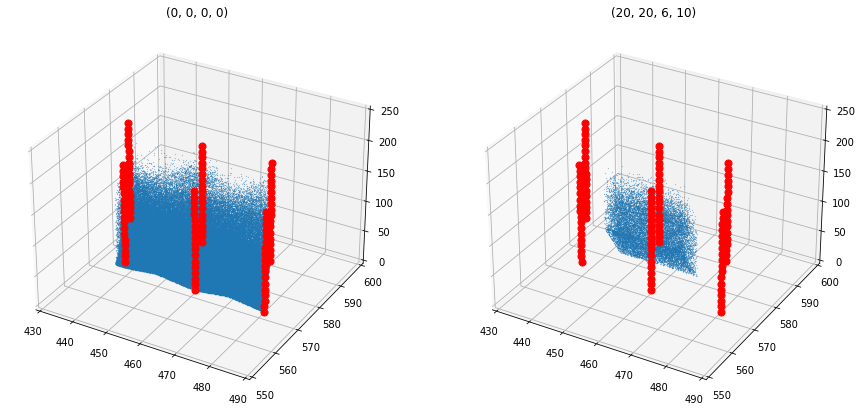

In [15]:
print("                                    " , id_df_b["ref"], "(meters)")
plot3D_loop(dfs,dom_positions)


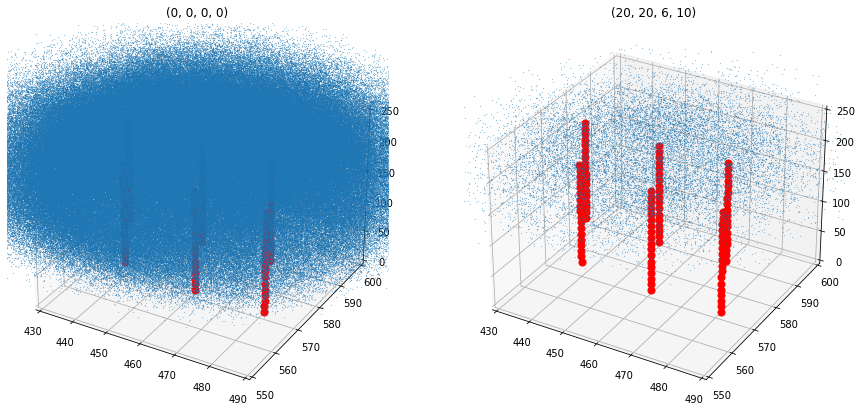

In [17]:
plot3D_loop_start(dfs,dom_positions)

                                     ('zinf', 'zsup', 'yred', 'xred') (meters)


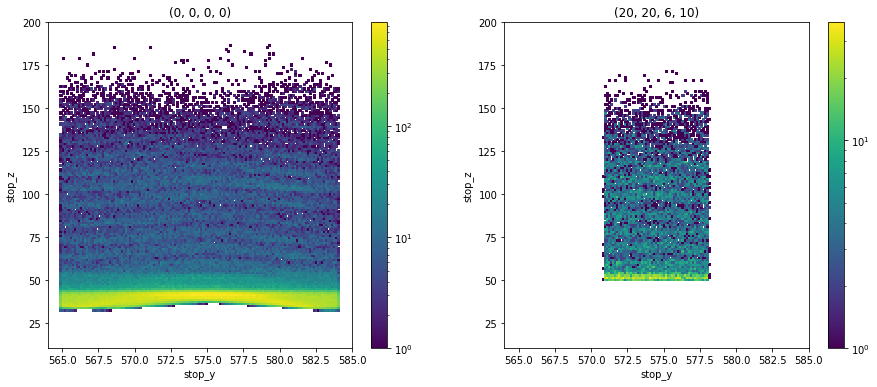

In [53]:
print("                                    " , id_df_b["ref"], "(meters)")
#Stop_y vs stop_z
plt.figure(figsize=(15,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plot2var_loop(df_dict[f"df_{i}"],i,"stop_y","stop_z",var1_min=564,var1_max=585,var2_min=10,var2_max=200) 
    
    

                                     ('zinf', 'zsup', 'yred', 'xred') (meters)


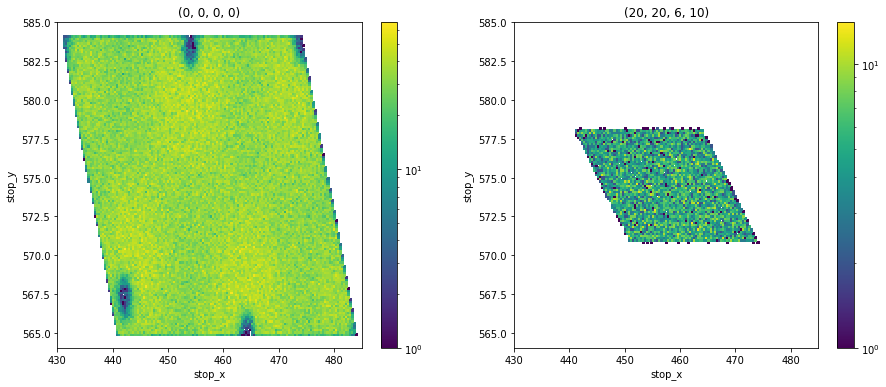

In [54]:
print("                                    " , id_df_b["ref"], "(meters)")
#Stop_y vs stop_x
plt.figure(figsize=(15,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plot2var_loop(df_dict[f"df_{i}"],i,"stop_x","stop_y",var1_min=430,var1_max=485,var2_min=564,var2_max=585)
    
    

                                     ('zinf', 'zsup', 'yred', 'xred') (meters)


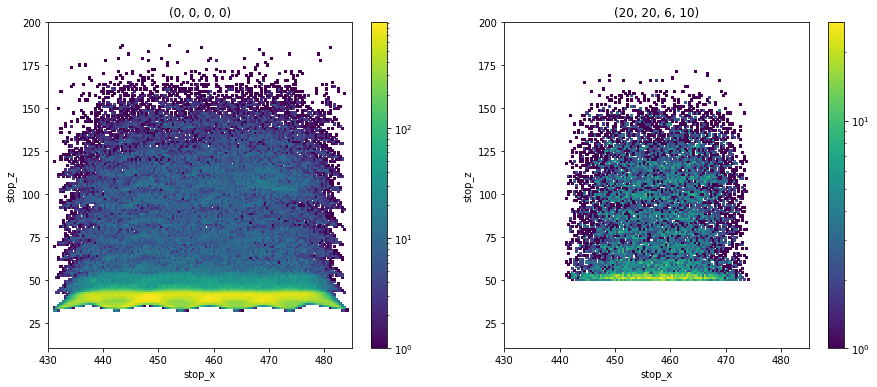

In [55]:
print("                                    " , id_df_b["ref"], "(meters)")
#Stop_x vs stop_z
plt.figure(figsize=(15,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plot2var_loop(df_dict[f"df_{i}"],i,"stop_x","stop_z",var1_min=430,var1_max=485,var2_min=10,var2_max=200)       
    

                                     ('zinf', 'zsup', 'yred', 'xred') (meters)


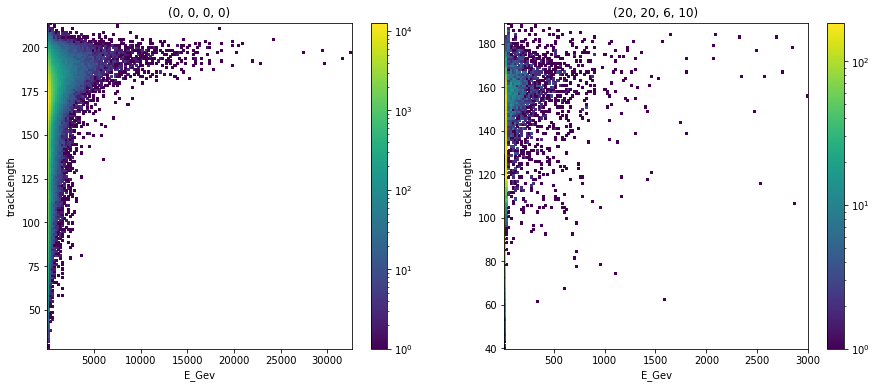

In [56]:
print("                                    " , id_df_b["ref"], "(meters)")
#E vs tracklenght
plt.figure(figsize=(15,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plot2var_loop(df_dict[f"df_{i}"],i,"E_Gev","trackLength")
    

                                     ('zinf', 'zsup', 'yred', 'xred') (meters)


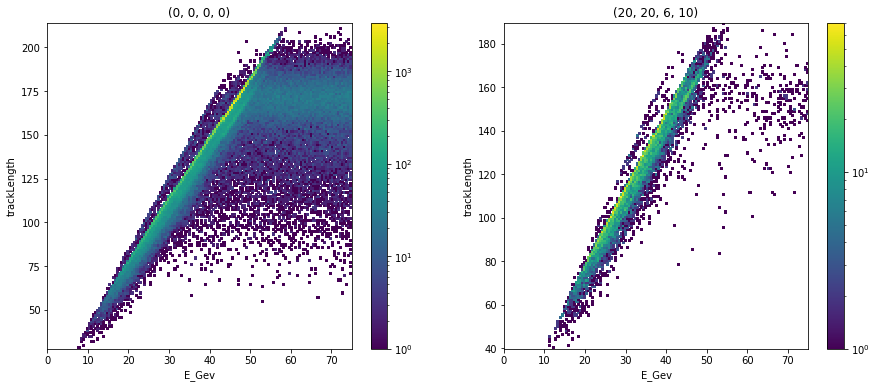

In [57]:
print("                                    " , id_df_b["ref"], "(meters)")
#E vs tracklenght
plt.figure(figsize=(15,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plot2var_loop(df_dict[f"df_{i}"],i,"E_Gev","trackLength",var1_min=0,var1_max=75)
    

In [17]:
def freq(df):
    """Compute frequency of events for a dataframe"""
    initial_time = df.iloc[0]["t_sec"]
    final_time = df.iloc[-1]["t_sec"]
    events = len(df)
    frequency = events/(final_time-initial_time)
    print("Frequency of stopping muon: ", frequency, " Hz")

In [21]:
print(id_df_b["ref"], "(meters)\n")
print("Without Volume cut ",id_df_b[0], ":")
print("data")
freq(df_0)
print("Simualtion")
freq(df_0_simu)

print("\nWith Volume cut ",id_df_b[1], ":")
freq(df_1)
print("Simualtion")
freq(df_1_simu)


('zinf', 'zsup', 'yred', 'xred') (meters)

Without Volume cut  (0, 0, 0, 0) :
data
Frequency of stopping muon:  0.03877950388506731  Hz
Simualtion
Frequency of stopping muon:  25.56636123447074  Hz

With Volume cut  (20, 20, 6, 10) :
Frequency of stopping muon:  0.0011569334912320825  Hz
Simualtion
Frequency of stopping muon:  0.8418405833542871  Hz


In [15]:
ls /home/stefanescu/internship/muonstopwork/rootfiles

data_dimitrisSelection.root*  muons_6.1_merged.root*


In [ ]:
##Run the simulation file

In [45]:
#Program to run for storing dataframes with severl cuts. If run this, also store the reference in the dictionary!!!


file = '/home/stefanescu/internship/muonstopwork/rootfiles/muons_6.1_merged.root'
E = 2.
lik = 200

i = 0
# df_0_simu, df_0_simu_mc = GUILLON_Cuts_simulations(file,E=2,lik=200,dir_z=-0.96,zsup=0,zinf=0,yred=0,xred=0)
# df_0_simu.to_pickle(f'dataframes_volumecut/df_vol_{i}_simu.pkl')
# df_0_simu_mc.to_pickle(f'dataframes_volumecut/df_vol_{i}_simu_mc.pkl')
# print("Data frame stored sucessfully\n")

i+=1
df_1_simu,df_1_simu_mc = GUILLON_Cuts_simulations(file,E=2,lik=200,dir_z=-0.96,zsup=20,zinf=20,yred=6,xred=10)
df_1_simu.to_pickle(f'dataframes_volumecut/df_vol_{i}_simu.pkl')
df_1_simu_mc.to_pickle(f'dataframes_volumecut/df_vol_{i}_simu_mc.pkl')
print("Data frame stored sucessfully\n")


File readed...
Filtering based on E and lik...
Filtration completed, filtering in dir_z...
Filtration complted, calculating stop positions...
Stop postions calculated
Computing Volume information...
Ylim is: [570.9, 578.1]
Zlim is: [50, 172]
Filtration finished
Recalculating stop postions
99.97% of events filtered
Creating dataframe with all desired variables for the filtered events
Data frame stored sucessfully



In [46]:
df_1_simu.head()

id  run_id  t_sec       t_ns                   len       E_Gev  \
0    42    7946     51  200000000  [160.95752735845878]  836.781439   
1   720    7946    797  400000000   [59.08569286566132]   17.183418   
2  3515    7946   3919  100000000  [153.49375799315433]  101.690923   
3  3551    7946   3959  600000000  [127.19410520995037]   35.241277   
4  4708    7946   5247  400000000  [114.12929096688211]   30.115935   

          lik     dir_x     dir_y     dir_z     start_x     start_y  \
0  490.382643 -0.122699 -0.081660 -0.989079  462.484200  590.691594   
1  220.181871 -0.176151  0.160094 -0.971257  467.608244  565.285931   
2  353.155223  0.129304  0.087987 -0.987694  437.160525  558.348360   
3  331.590796 -0.193922  0.060581 -0.979145  483.820825  567.381918   
4  228.735387  0.260733 -0.055539 -0.963812  432.296299  579.371779   

      start_z  trackLength      stop_x      stop_y      stop_z  
0  209.597755   160.957527  442.734888  577.547874   50.398091  
1  212.028464    59.085693  457.200239  574.745208  154.641056  
2  203.641465   153.493758  457.007857  571.853839   52.036653  
3  200.130404   127.194105  459.155049  575.087487   75.588989  
4  201.484855   114.129291  462.053516  573.033159   91.485650

In [47]:
df_1_simu_mc.head()

id  run_id  t_sec       t_ns    len status mother_id pdgid    E_Gev  \
0    42    7946     51  200000000  [0.0]    [0]      [-1]   [0]  565.536   
1   720    7946    797  400000000  [0.0]    [0]      [-1]   [0]  165.824   
2  3515    7946   3919  100000000  [0.0]    [0]      [-1]   [0]  173.628   
3  3551    7946   3959  600000000  [0.0]    [0]      [-1]   [0]  121.359   
4  4708    7946   5247  400000000  [0.0]    [0]      [-1]   [0]  115.485   

      dir_x     dir_y     dir_z   start_x   start_y  start_z  
0 -0.113627 -0.082344 -0.990105  1466.246  1840.540   1426.8  
1 -0.162613  0.164522 -0.972877  1036.313  1047.600    951.2  
2  0.133806  0.086418 -0.987232   399.592   534.819    475.6  
3 -0.191879  0.061721 -0.979476   537.890   549.957    475.6  
4  0.264564 -0.059372 -0.962539   356.618   596.358    475.6

In [49]:
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

In [50]:
MSE(df_1_simu_mc["E_Gev"],df_1_simu["E_Gev"])

559306.7417486681

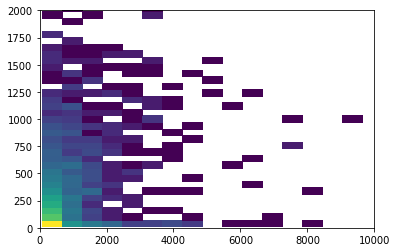

In [68]:
plt.hist2d(df_1_simu_mc["E_Gev"],df_1_simu["E_Gev"],bins=[100,100], norm=mpl.colors.LogNorm())
plt.xlim([0,10000])
plt.ylim([0,2000])
plt.show()

In [43]:
def GUILLON_Cuts_simulations(file,E=2,lik=200,dir_z=None,zsup=0,zinf=0,yred=0,xred=0):
    """Returns dataframe for a km3net root file, cutting events based on E, lik, dir_z, Volume.
    Default values: E=2.GeV, lik=200, dir_z=All,Volume=All initial volume, """
    
    
    #Read file using kio
    f = kio.OfflineReader(file)
    print("File readed...")
    
    #total number of events
    total_events = len(f.events)
    
    print("Filtering based on E and lik...")
    #array of booleans, true if n_tracks >= 1
    haveTrk = np.array(f.events.n_tracks, dtype=bool)
    
    #array of booleans for E and lik filters + haveTrk
    cuts_1 = np.array((f.events.tracks.E[haveTrk][:,0] >= E) & (f.events.tracks.lik[haveTrk][:,0] >= lik))
    print("Filtration completed, filtering in dir_z...")
    
    #filter for z_direction, if not specified, just an array of True values
    if dir_z:
        cuts_z = np.array(f.events.tracks.dir_z[haveTrk][:,0] <= dir_z)
    else:
        cuts_z = np.broadcast_to(True,(1,total_events))
        
        
    #cuts of E, lik, z boolean array
    cuts_2 = cuts_1 & cuts_z
    
    print("Filtration complted, calculating stop positions...")
    
    
    #Call Stops function to compute stop postions based on cuts_2, as well as start positions and tracklenght
    pos_stop, pos_stop_bis, pos_start, trackLength = Stops(file,cuts_2)
    
    print("Stop postions calculated")
    print("Computing Volume information...")
    
    #Call VolumeCut function to compute cuts_volume 
    cuts_volume, coordinates = VolumeCut(pos_stop_bis,zsup,zinf,yred,xred)
    
    
    #Perform final cut, using cuts_2 and cuts_R_dom
    filtered_events = f.events[cuts_2][cuts_volume]
    
    print("Filtration finished")
    
    #Calculate again final postions for the data, based on the two cuts, in order to have a proper dataframe, and don't loose
    #track of events id... (Due to the fact of the double filtration, step needed for solving computing problems)
    print("Recalculating stop postions")
        
    #Array of initial position x, y and z coordinates for each event considering the cuts_2 and cuts_R_dom
    pos_start_f = [f.events.tracks.pos_x[cuts_2][cuts_volume][:,0].__array__(),f.events.tracks.pos_y[cuts_2][cuts_volume][:,0].__array__(),f.events.tracks.pos_z[cuts_2][cuts_volume][:,0].__array__()] 

    #Add all positions together, array of arrays
    pos_start_f = np.stack(pos_start_f)
    
    #Fitinf for each track of each event. Get all fitinf of 0th and 10th element of fitinf object (Trak lenght)
    trackLength_f = f.events.tracks.fitinf[cuts_2][cuts_volume][:,0,10].__array__()
    
    #stop postion, as pos start + track
    pos_stop_x_f  = pos_start_f[0,:] + f.events.tracks.dir_x[cuts_2][cuts_volume][:,0].__array__()*trackLength_f # for x
    pos_stop_y_f  = pos_start_f[1,:] + f.events.tracks.dir_y[cuts_2][cuts_volume][:,0].__array__()*trackLength_f # for y
    pos_stop_z_f  = pos_start_f[2,:] + f.events.tracks.dir_z[cuts_2][cuts_volume][:,0].__array__()*trackLength_f # for z

    #Add all positions together, array of arrays
    pos_stop_f = np.stack((pos_stop_x_f, pos_stop_y_f, pos_stop_z_f))

        
    #Calculate % of filtered events
    filtered_events_n = len(filtered_events)
    print(str("{:.2f}".format((total_events-filtered_events_n)*100/total_events))+"% of events filtered")
    
    #Create the dataframe, including also id!!!
    print("Creating dataframe with all desired variables for the filtered events")
    
#     #DataFrame all list
#     data_tuples = list(zip(filtered_events.id,filtered_events.run_id,filtered_events.t_sec,filtered_events.t_ns,filtered_events.events.tracks.len,filtered_events.events.tracks.E[:,0].__array__(),filtered_events.events.tracks.lik[:,0].__array__(),filtered_events.events.tracks.dir_x[:,0].__array__(),filtered_events.events.tracks.dir_y[:,0].__array__(),filtered_events.events.tracks.dir_z[:,0].__array__(),pos_start_f[0],pos_start_f[1],pos_start_f[2],trackLength_f,pos_stop_f[0],pos_stop_f[1],pos_stop_f[2]))
#     df_cuts_tracks = pd.DataFrame(data_tuples, columns=['id','run_id','t_sec','t_ns','len','E_Gev',"lik","dir_x","dir_y","dir_z","start_x","start_y","start_z","trackLength","stop_x","stop_y","stop_z"])
    
    data_tuples = list(zip(filtered_events.id,filtered_events.run_id,filtered_events.t_sec,filtered_events.t_ns,filtered_events.tracks.len,filtered_events.tracks.E[:,0].__array__(),filtered_events.tracks.lik[:,0].__array__(),filtered_events.tracks.dir_x[:,0].__array__(),filtered_events.tracks.dir_y[:,0].__array__(),filtered_events.tracks.dir_z[:,0].__array__(),pos_start_f[0],pos_start_f[1],pos_start_f[2],trackLength_f,pos_stop_f[0],pos_stop_f[1],pos_stop_f[2]))
    df_cuts_tracks = pd.DataFrame(data_tuples, columns=['id','run_id','t_sec','t_ns','len','E_Gev',"lik","dir_x","dir_y","dir_z","start_x","start_y","start_z","trackLength","stop_x","stop_y","stop_z"])
    
    
    
    data_tuples = list(zip(filtered_events.id,filtered_events.run_id,filtered_events.t_sec,filtered_events.t_ns,filtered_events.mc_tracks.len,filtered_events.mc_tracks.status,filtered_events.mc_tracks.mother_id,filtered_events.mc_tracks.pdgid,filtered_events.mc_tracks.E[:,0].__array__(),filtered_events.mc_tracks.dir_x[:,0].__array__(),filtered_events.mc_tracks.dir_y[:,0].__array__(),filtered_events.mc_tracks.dir_z[:,0].__array__(),filtered_events.mc_tracks.pos_x[:,0].__array__(),filtered_events.mc_tracks.pos_y[:,0].__array__(),filtered_events.mc_tracks.pos_z[:,0].__array__()))
    df_cuts_mc_tracks = pd.DataFrame(data_tuples, columns=['id','run_id','t_sec','t_ns','len','status','mother_id','pdgid','E_Gev',"dir_x","dir_y","dir_z","start_x","start_y","start_z",])
    
    
    return df_cuts_tracks, df_cuts_mc_tracks

                                     ('zinf', 'zsup', 'yred', 'xred') (meters)


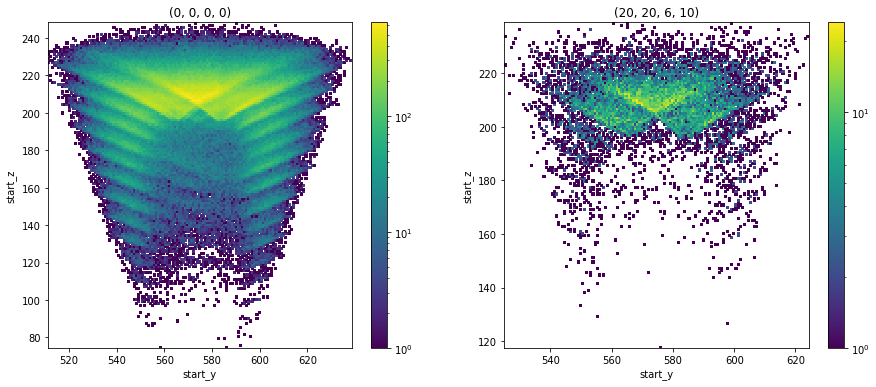

In [19]:
print("                                    " , id_df_b["ref"], "(meters)")
#Stop_y vs stop_z
plt.figure(figsize=(15,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plot2var_loop(df_dict[f"df_{i}"],i,"start_y","start_z")#,var1_min=564,var1_max=585,var2_min=10,var2_max=200) 
    


                                     ('zinf', 'zsup', 'yred', 'xred') (meters)


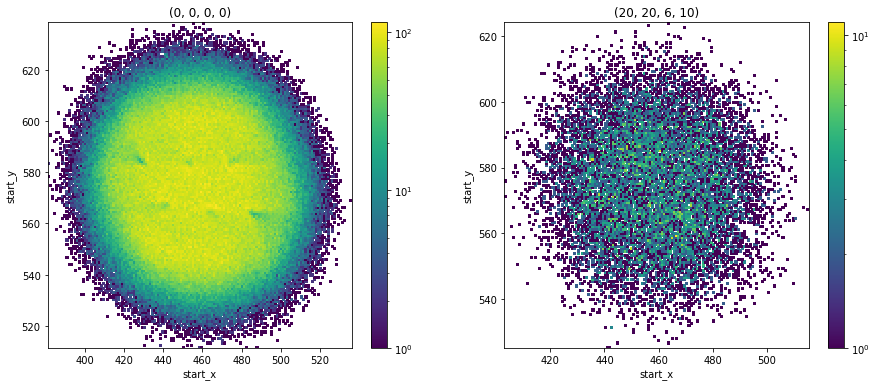

In [21]:
print("                                    " , id_df_b["ref"], "(meters)")
#Stop_y vs stop_z
plt.figure(figsize=(15,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plot2var_loop(df_dict[f"df_{i}"],i,"start_x","start_y")#,var1_min=564,var1_max=585,var2_min=10,var2_max=200) 
    


                                     ('zinf', 'zsup', 'yred', 'xred') (meters)


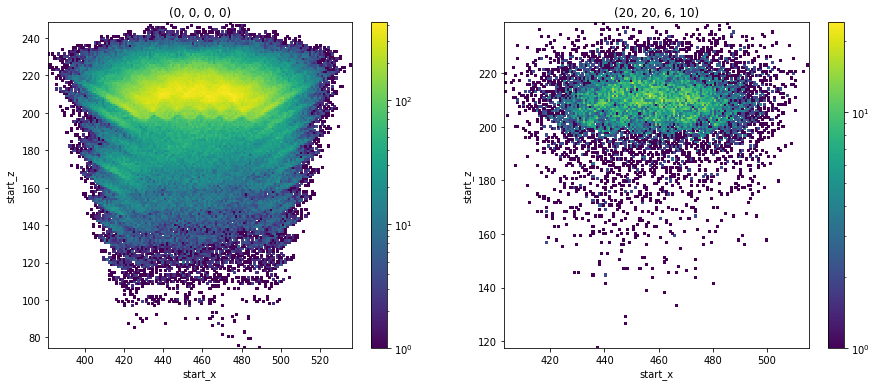

In [22]:
print("                                    " , id_df_b["ref"], "(meters)")
#Stop_y vs stop_z
plt.figure(figsize=(15,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plot2var_loop(df_dict[f"df_{i}"],i,"start_x","start_z")#,var1_min=564,var1_max=585,var2_min=10,var2_max=200) 
    
